<a href="https://colab.research.google.com/github/mohitshah3111999/Facial-Expression-Recognition/blob/main/BTP_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

np.random.seed(2)

import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau

from keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dropout, Flatten, Dense
from keras.layers import BatchNormalization

from keras.models import load_model

import os
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
import tensorflow_hub as hub

from google.colab import drive

In [ ]:
drive.mount('/content/drive')
%cd drive/MyDrive/facial_expression/

Mounted at /content/drive
/content/drive/MyDrive/facial_expression


In [ ]:
data = pd.read_csv("fer2013/fer2013.csv")
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [ ]:
groups = [g for _, g in data.groupby('Usage')]
train = groups[2]
val = groups[1]
test = groups[0]

In [ ]:
train = train.drop(labels=['Usage'], axis=1)
val = val.drop(labels=['Usage'], axis=1)
test = test.drop(labels=['Usage'], axis=1)

Y_train = train["emotion"]
Y_val = val["emotion"]
Y_test = test["emotion"]

X_train = train["pixels"]
X_val = val["pixels"]
X_test = test["pixels"]

In [ ]:
def preprocess(X):
    X = np.array([np.fromstring(image, np.uint8, sep=' ') for image in X])
    X = X/255.0
    X = X.reshape(-1, 48, 48, 1)
    return X

In [ ]:
X_train = preprocess(X_train)
X_val = preprocess(X_val)
X_test = preprocess(X_test)

In [ ]:
model = Sequential([
                    Conv2D(32, (3,3), padding="Same", activation='relu', input_shape=(48,48,1)),
                    BatchNormalization(),
                    Conv2D(32, (5,5), padding="Same", activation='relu'),
                    MaxPooling2D((2,2)),
                    Dropout(0.5),
                    Conv2D(64, (3,3), padding="Same", activation='relu'),
                    BatchNormalization(),
                    Conv2D(64, (5,5), padding="Same", activation='relu'),
                    MaxPooling2D((2,2)),
                    Dropout(0.5),
                    Conv2D(128, (3,3), padding="Same", activation='relu'),
                    BatchNormalization(),
                    Conv2D(128, (5,5), padding="Same", activation='relu'),
                    MaxPooling2D((2,2)),
                    Dropout(0.5),
                    Flatten(),
                    Dense(256, activation='relu'),
                    Dense(7, activation='softmax')                   
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
optimizer = Adam(lr = 0.001)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
file_name = 'best_model_custom.h5'
checkpoint_path= os.path.join('checkpoint',file_name)

call_back = ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_accuracy',
                                                 verbose=1,
                                                 save_freq='epoch',
                                                 save_best_only=True,
                                                 save_weights_only=False,
                                                 mode='max')

stopping = EarlyStopping(monitor='val_accuracy', mode='max', verbose=1, patience=20)
lr_anneal = ReduceLROnPlateau(monitor = 'val_accuracy', patience=3, factor=0.2, min_lr=1e-6)

callbacks_list = [call_back, stopping, lr_anneal]

In [ ]:
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(X_train, Y_train, validation_data=[X_val, Y_val], epochs=50, batch_size = 100, callbacks=callbacks_list)

Epoch 1/50
288/288 [==============================] - ETA: 0s - loss: 2.0208 - accuracy: 0.2496
Epoch 00001: val_accuracy improved from -inf to 0.24937, saving model to checkpoint/best_model_custom.h5
288/288 [==============================] - 16s 24ms/step - loss: 2.0208 - accuracy: 0.2496 - val_loss: 1.8652 - val_accuracy: 0.2494 - lr: 0.0010
Epoch 2/50
285/288 [============================>.] - ETA: 0s - loss: 1.6176 - accuracy: 0.3598
Epoch 00002: val_accuracy improved from 0.24937 to 0.35497, saving model to checkpoint/best_model_custom.h5
288/288 [==============================] - 5s 18ms/step - loss: 1.6170 - accuracy: 0.3603 - val_loss: 1.7005 - val_accuracy: 0.3550 - lr: 0.0010
Epoch 3/50
285/288 [============================>.] - ETA: 0s - loss: 1.4532 - accuracy: 0.4318
Epoch 00003: val_accuracy improved from 0.35497 to 0.43968, saving model to checkpoint/best_model_custom.h5
288/288 [==============================] - 5s 18ms/step - loss: 1.4518 - accuracy: 0.4324 - val_loss

In [ ]:
%cd checkpoint/
os.listdir()

/content/drive/My Drive/facial_expression/checkpoint


['best_model_resnet_2.h5', 'best_model_custom.h5', 'best_model_mobilenet.h5']

In [ ]:
model = load_model("best_model_custom.h5", custom_objects={'KerasLayer':hub.KerasLayer})
model.summary()
%cd ..

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 32)        320       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 32)        25632     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 24, 24, 64)        1

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Predict the values from the validation dataset
Y_pred = model.predict(X_test)
# Convert predictions classes to one hot vectors 
Y_pred_classes = np.argmax(Y_pred,axis = 1) 

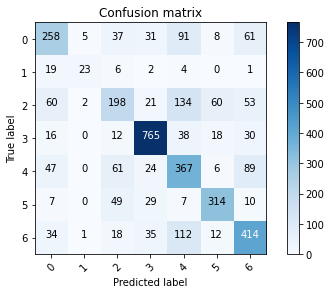

In [ ]:
confusion_mtx = confusion_matrix(Y_test, Y_pred_classes) 
# plot the confusion matrix
plot_confusion_matrix(confusion_mtx, classes = range(7))

In [ ]:
score, acc = model.evaluate(X_test, Y_test, batch_size=100)
print('Test loss:', score)
print("Test accuracy:", acc)

36/36 [==============================] - 0s 6ms/step - loss: 0.9902 - accuracy: 0.6517
Test score: 0.9901766180992126
Test accuracy: 0.6517135500907898


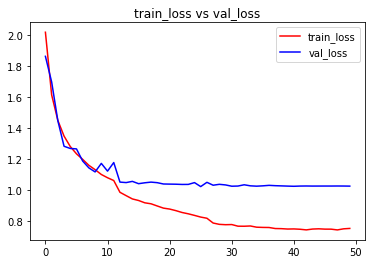

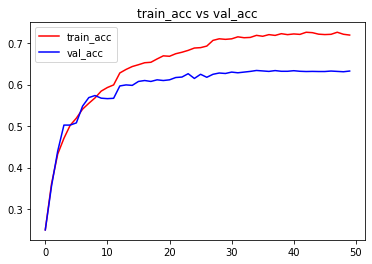

In [ ]:
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import confusion_matrix
import pickle

train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

epochs = range(len(train_acc))

plt.plot(epochs, train_loss, 'r', label='train_loss')
plt.plot(epochs, val_loss, 'b', label='val_loss')
plt.title('train_loss vs val_loss')
plt.legend()
plt.figure()

plt.plot(epochs, train_acc, 'r', label='train_acc')
plt.plot(epochs, val_acc, 'b', label='val_acc')
plt.title('train_acc vs val_acc')
plt.legend()